In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import math
import plotly.graph_objects as go
from collections import OrderedDict
from matplotlib.lines import Line2D  # Import for creating custom legend markers
import json
import copy
import random
import re
import seaborn as sns
import importlib


# Import BW25 packages
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa
import brightway2 as bw 
from bw2calc import LeastSquaresLCA

In [2]:
from  standards import *
import Monte_Carlo as MC
import life_cycle_assessment as lc


importlib.reload(MC)

importlib.reload(lc)

Folder name Results created
Folder name Results created


<module 'life_cycle_assessment' from 'c:\\Users\\ruw\\Desktop\\RA\\Single-use-vs-multi-use-in-health-care\\Brighway\\life_cycle_assessment.py'>

In [3]:
save_dir = results_folder('Results')

file_name = r'Results\Mango - CONSQ.xlsx'
file_name_sub = r'Results\Mango sub - CONSQ.xlsx'

sheet_name = 'Mango'

database_project = "RA - Rune"
database_name = 'DU consequential final'

flows = ['sc1 - No DU', 'sc2 - CDU', 'sc3 - MDU']
flow_legend = ['No DU', 'CDU', 'MDU']



Folder name Results created


In [4]:
FU, FU_proc, impact_category, plot_x_axis, sub_product_details = lc.LCA_initialization(database_project, database_name, flows)
# dct = lc.process_filter(FU)

Biosphere database already present!!! No setup is needed
Initialization is completed


In [5]:
# Caculating the LCA results
FU, FU_proc, impact_category, plot_x_axis, sub_product_details = lc.LCA_initialization(database_project, database_name, flows)
impat =  impact_category
# df = lc.life_cycle_impact_assessment(flows, FU, impat, FU_proc)

# lc.save_LCA_results(df, file_name, sheet_name, impat)
df_test = lc.import_LCA_results(file_name, flows, impat)

Biosphere database already present!!! No setup is needed
Initialization is completed


In [6]:
# Processing the LCA results
sub_proccess, amount = lc.obtaining_sub_process(sub_product_details)
FU_sub, FU_sub_proc, idx = lc.sub_process_initilization(sub_proccess, FU, database_project, 'df_idx_rune')
flow_count, flow_sub, functional_unit_sub = lc.FU_contibution_initilization(FU_sub, FU_sub_proc)


Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initiali

In [7]:
functional_unit_sub_new = lc.process_update(FU, functional_unit_sub)
# df_cont = lc.LCIA_contribution(impat[1], flow_count, FU_sub_proc, functional_unit_sub_new, amount, idx)
# lc.save_LCA_results(df_cont, file_name_sub, sheet_name, impat)
df_c = lc.import_LCA_results(file_name, flows, impat)

In [9]:
df_tot, df_scaled, df_col  = lc.dataframe_element_scaling(df_test)
plt_leg = lc.dataframe_column_structure(impat)
# df_scaled

In [26]:
df_GWP = df_test[df_test.columns[1]].to_frame()
df_GWP

,EF v3.1 EN15804
,climate change
,global warming potential (GWP100)
sc1 - No DU,"[[Steel cylinder, 0.005456229514756893], [nitr..."
sc2 - CDU,"[[CDU updated, 0.12862424689466137], [Steel cy..."
sc3 - MDU,"[[MDU updated, 0.3591249304896528], [Steel cyl..."


In [33]:
# df_GWP = copy.deepcopy(df_test)
x_axis = []
GWP_value = []

for df_size in range(len(df_GWP)):
    lst_x = []
    lst_GWP = []
    gwp_tot = 0
    for key in df_GWP.keys():
        for lst_size in range(len(df_GWP[key][df_size])):
            x = df_GWP[key][df_size][lst_size][0]
            gwp = df_GWP[key][df_size][lst_size][1]
            # print(x, gwp)
            if '- FU' in x:
                #print(key)
                x = x.replace(f' - FU', '')
            if 'Use' in x:           
                x = 'Labor'
            if 'nitrous' in x:
                x = 'N2O prod.'
            if 'market for electricity' in x:
                x = 'Avoided electricity'
            if 'Steel' in x:
                x = 'Cylinder prod.'

            if '50L' in x:
                x = x.replace(' 50L', '')
            if 'updated' in x:
                x = x.replace('updated', 'prod.')
            if 'avoided' in x:
                x = x.replace('avoided', 'Avoided')

            lst_x.append(x)
            lst_GWP.append(gwp)
            gwp_tot += gwp
    
    lst_GWP.append(gwp_tot)
    lst_x.append('Total')
    x_axis.append(lst_x)
    GWP_value.append(lst_GWP)

x_axis

C:\Users\ruw\AppData\Local\Temp\7\ipykernel_30288\1872243883.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for lst_size in range(len(df_GWP[key][df_size])):
C:\Users\ruw\AppData\Local\Temp\7\ipykernel_30288\1872243883.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = df_GWP[key][df_size][lst_size][0]
C:\Users\ruw\AppData\Local\Temp\7\ipykernel_30288\1872243883.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gwp = 

[['Cylinder prod.', 'N2O prod.', 'Labor', 'EoL cylinder', 'Total'],
 ['CDU prod.',
  'Cylinder prod.',
  'N2O prod.',
  'Labor',
  'EoL CDU',
  'EoL cylinder',
  'Avoided heat',
  'Avoided electricity',
  'Total'],
 ['MDU prod.',
  'Cylinder prod.',
  'N2O prod.',
  'Labor',
  'EoL MDU',
  'EoL cylinder',
  'Avoided heat',
  'Avoided electricity',
  'Total']]

In [63]:
# Categories definitions
categories = ["Raw mat. + prod.", "Use", "EoL", "Total"]
category_mapping = {
    "Raw mat. + prod.": ["Cylinder prod.", "N2O prod.", "CDU prod.", "MDU prod.", "Production"],
    "Use": ["Labor"],
    "EoL": ["EoL cylinder", "EoL CDU", "EoL MDU", "Avoided heat", "Avoided electricity"],
    "Total": ["Total"]
}

# Ensure the legend displays items in the category order
ordered_legend = {key: [] for key in category_mapping}

for x_lst in range(len(x_axis)):
    for x in range(len(x_axis[x_lst])):
        
        for key, item in category_mapping.items():
                if x_axis[x_lst][x] in item:
                    ordered_legend[key].append(x_axis[x_lst][x])

plot_legend = {key: [] for key in category_mapping}
temp = []

for key,value in ordered_legend.items():
    #print(key, value)
    for val in value:
        if val not in temp:
            temp.append(val)
            #print(val)
            plot_legend[key].append(val)


colors = plot_colors(temp,'turbo')
plot_legend

{'Raw mat. + prod.': ['Cylinder prod.', 'N2O prod.', 'CDU prod.', 'MDU prod.'],
 'Use': ['Labor'],
 'EoL': ['EoL cylinder',
  'EoL CDU',
  'Avoided heat',
  'Avoided electricity',
  'EoL MDU'],
 'Total': ['Total']}

In [64]:
columns_to_plot = df_scaled.columns

0 sc1 - No DU
1 sc2 - CDU
2 sc3 - MDU


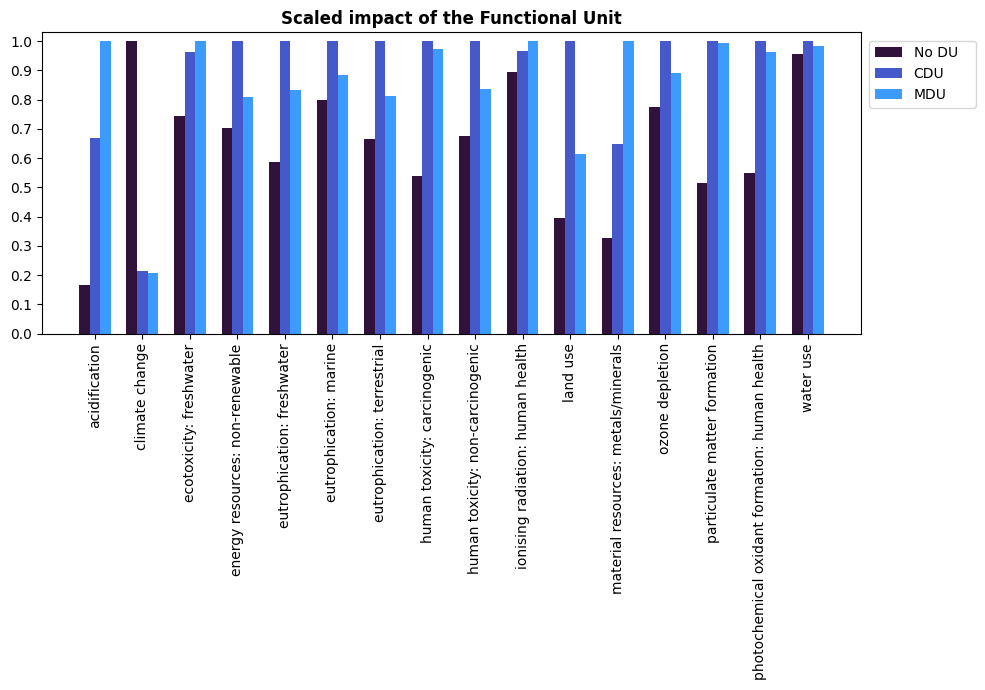

In [65]:
index_list = list(df_test.index.values)

# Plotting
fig, ax = plt.subplots(figsize=(9,7))

num_processes = len(df_scaled)
bar_width = 1/(len(index_list) + 1.5) 
idex = np.arange(len(columns_to_plot))

# Plotting each group of bars
for i, process in enumerate(df_scaled.index):
    print(i, process)
    values = df_scaled.loc[process, columns_to_plot].values
    ax.bar((idex + i * bar_width), values, bar_width, label=process, color=colors[i])
    

# Setting labels and title
ax.set_title('Scaled impact of the Functional Unit',weight='bold')
ax.set_xticks(idex + bar_width )
ax.set_xticklabels(plot_x_axis)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.ylim(0,1.03)

ax.legend(flow_legend,bbox_to_anchor=(1.01, .75, .13, 0), loc="lower left",
            mode="expand", borderaxespad=0,  ncol=1)

plt.tight_layout()
# plt.savefig(os.path.join(save_dir, img_res), bbox_inches='tight')
plt.show()

In [66]:
directory = 'C:\\Users\\ruw\\Desktop\\RA\\'


In [67]:
lst_scaled = lc.LCIA_normalization(directory, df_tot)

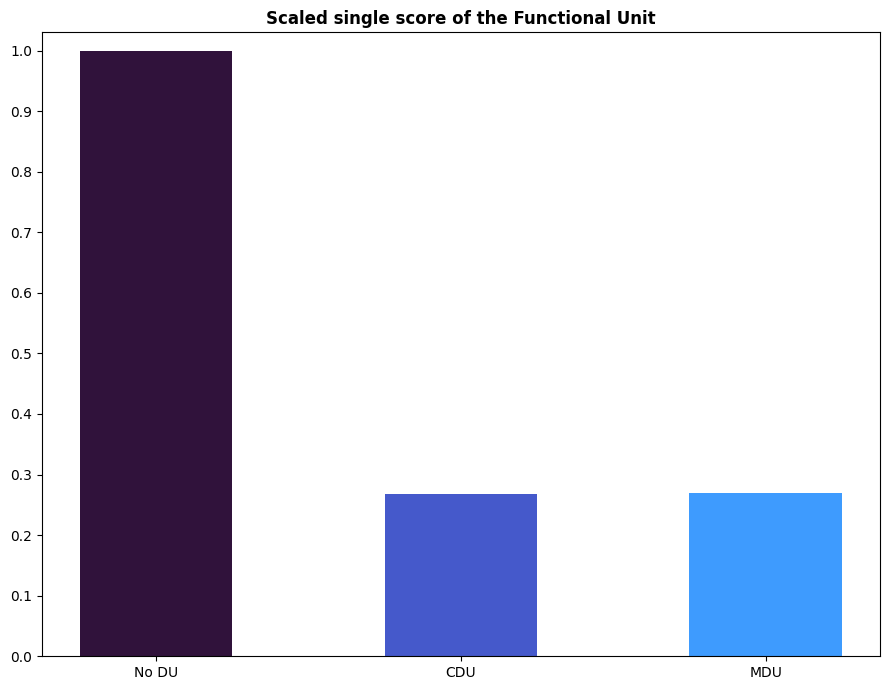

In [68]:
# Plotting
fig, ax = plt.subplots(figsize=(9,7))

num_processes = len(df_scaled)
bar_width = 1/(len(index_list)-1) 
index = np.arange(len(index_list))   

ax.bar(index + bar_width, lst_scaled, bar_width, label=index_list, color=colors)

# Setting labels and title
ax.set_title('Scaled single score of the Functional Unit',weight='bold')
ax.set_xticks(index + bar_width )
ax.set_xticklabels(flow_legend)
#plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.ylim(0,1.03)

plt.tight_layout()
# plt.savefig(os.path.join(save_dir, img_res), bbox_inches='tight')
plt.show()

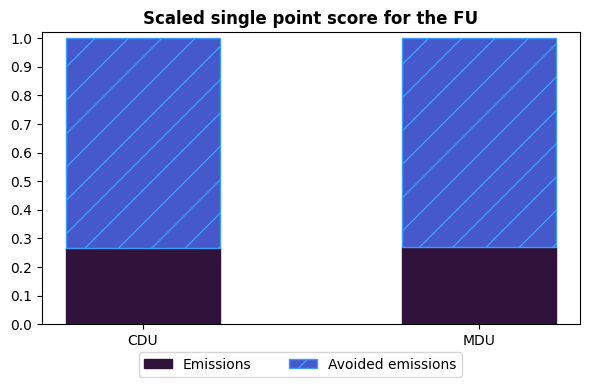

In [69]:
# Calculate bottom and top parts
bottoms = lst_scaled[1:]
last_value = lst_scaled[0]
tops = [last_value - bottom for bottom in bottoms]

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))

# Bar positions
bar_positions = [0, 1.75]

# Bottom parts (first two values)
ax.bar(bar_positions, bottoms, label='Emissions',color=colors[0], edgecolor=colors[0])

# Top parts (values after subtraction) with hatching
ax.bar(bar_positions, tops, bottom=bottoms, label='Avoided emissions', color=colors[1], edgecolor=colors[2], hatch='/')


# Adding labels and titlecolors[1]
ax.set_xticks(bar_positions)
ax.set_xticklabels(['CDU', 'MDU'])

# Setting labels and title
ax.set_title('Scaled single point score for the FU',weight='bold')
plt.yticks(np.arange(0, 1.02, step=0.1))
plt.ylim(0, 1.02)

ax.legend(['Emissions', 'Avoided emissions'], bbox_to_anchor=(0.18, -0.18, 0.6, 0.2), loc="lower left",
            mode="expand", borderaxespad=0,  ncol=2)

# ax.plot(bottoms,'o',color=colors[1])
# Show the plot
plt.tight_layout()
#plt.savefig(os.path.join(save_dir, 'GWP_res.jpg'), bbox_inches='tight')
plt.show()

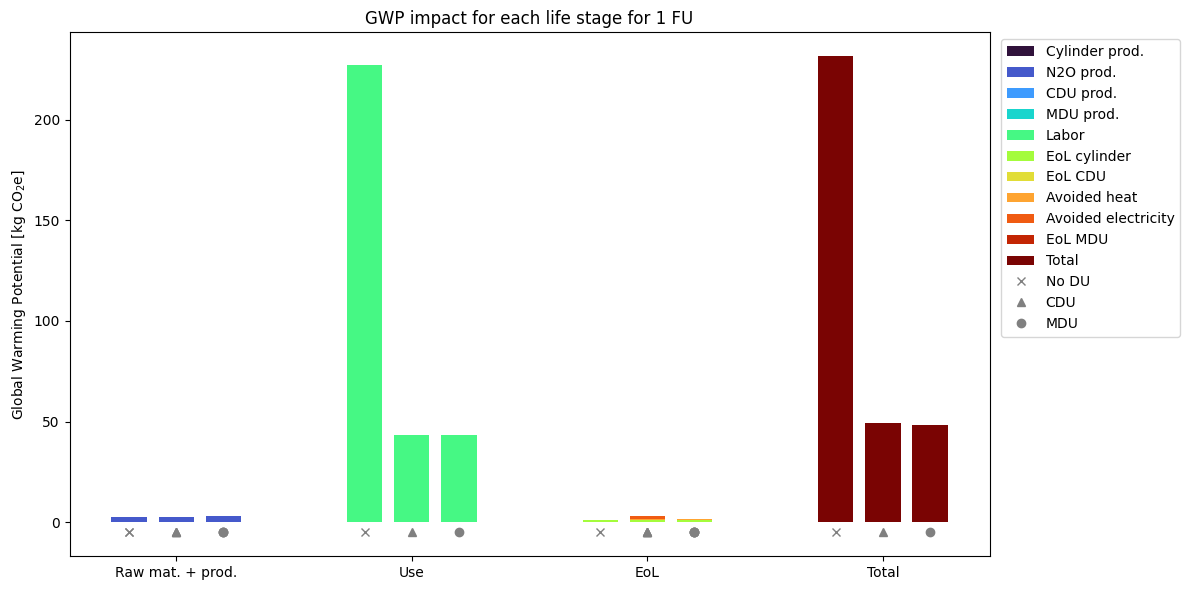

In [70]:

color_map = {}
#unique_processes = {process for sublist in x_axis for process in sublist}
for i, process in enumerate(temp):
    color_map[process] = colors[i]
    #print(process, i)



# Initialize an ordered dictionary for legend_handles to maintain the order
legend_handles = OrderedDict()

# Initialize legend_handles with keys from plot_legend and empty lists
for process in temp:
    legend_handles[process] = None

# Plotting logic
if len(x_axis) == len(GWP_value):
    num_scenarios = len(GWP_value)  # Number of scenarios
    bar_width = 0.15  # Width of the bars for each scenario
    space_between_scenarios = 0.05  # Space between each scenario set
    index = np.arange(len(categories))  # X-axis index positions for the categories

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    scenario_marker = ['x', '^', 'o']  # List of markers for scenarios
    all_markers = []  # List to store Line2D objects for markers

    # Main plotting logic
    for scenario in range(num_scenarios):
        bottom_positive = np.zeros(len(categories))  # Initialize the bottom array for positive values
        bottom_negative = np.zeros(len(categories))  # Initialize the bottom array for negative values
        scenario_index = index + scenario * (bar_width + space_between_scenarios)

        for length in range(len(x_axis[scenario])):
            process_name = x_axis[scenario][length]
            value = GWP_value[scenario][length]

            # Determine which category this process falls into
            for i, category in enumerate(categories):
                if any(keyword in process_name for keyword in category_mapping[category]):
                    # Assign color based on the process name
                    color = color_map[process_name]

                    # Create a bar with the specific color
                    if value >= 0:
                        bar = ax.bar(scenario_index[i], value, bar_width,
                                    label=f"{process_name}" if legend_handles[process_name] is None else "",
                                    bottom=bottom_positive[i],
                                    color=color)
                        bottom_positive[i] += value
                    else:
                        bar = ax.bar(scenario_index[i], value, bar_width,
                                    label=f"{process_name}" if legend_handles[process_name] is None else "",
                                    bottom=bottom_negative[i],
                                    color=color)
                        bottom_negative[i] += value

                    # Add the bar to the corresponding process in legend_handles
                    if legend_handles[process_name] is None:
                        legend_handles[process_name] = bar

                    # Add plot markers (symbols) at the bottom
                    ax.plot(scenario_index[i], -5, marker=scenario_marker[scenario], color='gray')

                    break

    # Add custom markers to the legend
    for i, marker in enumerate(scenario_marker):
        all_markers.append(Line2D([0], [0], marker=marker, color='gray', linestyle='None'))

    # Set x-axis labels and ticks, adjusting to account for spacing
    tick_positions = index + (num_scenarios - 1) * (bar_width + space_between_scenarios) / 2
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(categories)

    # Axis limits
    # ax.set_ylim(-.45, 3.55)
    # ax.set_yticks(np.arange(-0.5, 3.6, step=0.25))
    ax.set_ylabel("Global Warming Potential [kg CO$_2$e]")
    ax.set_title('GWP impact for each life stage for 1 FU')

    # Add markers to legend_handles for display at the bottom of the legend
    valid_legend_handles = [(k, v) for k, v in legend_handles.items() if v is not None]
    legend_handles_for_display = valid_legend_handles + [(flow_legend[i], marker) for i, marker in enumerate(all_markers)]

    if legend_handles_for_display:
        ax.legend(handles=[v for k, v in legend_handles_for_display], labels=[k for k, v in legend_handles_for_display], bbox_to_anchor=(1.005, 1), loc='upper left')

    plt.tight_layout()
    #plt.savefig(os.path.join(save_dir, f'LC_impact_ofir_APOS.jpg'), bbox_inches='tight')
    plt.show()

else:
    print('The x-axis and GWP values have different sizes')


In [71]:
# importlib.reload(MC)  # Reloads the module after modification

# iterations = 2
# impact_method = impact_category[1]
# file_MC = 'monte_carlo_simulations_Rune.xlsx'

# MC_res, data = MC.MC_simulation(iterations, flows, database_name, impact_method, file_MC)
# MC.MC_graphs(flow_legend, data, iterations)


In [72]:
# file_MC = 'monte_carlo_simulations_Rune.xlsx'
# # Create an Excel writer object
# with pd.ExcelWriter(file_MC, engine='xlsxwriter') as writer:
#     for i, dataframe in enumerate(Monte_Carlo_dct.values()):
#         # Get the sheet name and clean it
#         sheet_name = clean_sheet_name(impact_category[i][1])
#         # Save the dataframe to the corresponding sheet
#         dataframe.to_excel(writer, sheet_name=sheet_name)